# Split up data

In [10]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
from scipy.fft import fftshift
import math
import mne
from IPython import get_ipython
import re
from collections import OrderedDict
from statistics import mean, median 
import random
import scipy
import seaborn
import scipy.ndimage as sp
import tqdm as tqdm
from PIL import Image 
import seaborn as sns
sns.set()



In [11]:
base_dir = os.getcwd()
print(f'current directory: {base_dir}')

dataset_dir = os.path.join(base_dir, 'datasets/source_data/PhysioNet/OR')
print(f'datasets directory: {dataset_dir}')

current directory: /Users/alicialarsen/Documents/TUe/Honors/MedAI/VGG16_V2
datasets directory: /Users/alicialarsen/Documents/TUe/Honors/MedAI/VGG16_V2/datasets/source_data/PhysioNet/OR


In [12]:
# Combine datasets _Sdb and _l

def get_all_users(dataset_dir) -> dict:
    """Returns a dictionary with user-IDs as keys and empty values.
    """
    user_dict = {}
    pattern = '\d+'
    for file in os.listdir(dataset_dir):
        try: user_id = int(re.findall(pattern, file)[0])
        except: pass
        user_dict[user_id] = ''
    return dict(OrderedDict(sorted(user_dict.items())))

def column_renaming():
    """Used to rename SDB dataframes in function 'combine_sdb_l'.
    """
    old_columns = [i for i in range(0, 100, 1)]
    new_columns = [i/2 for i in range(0, 100, 1)]
    return {old_columns[i]: new_columns[i] for i in range(0, 100)}

def combine_sdb_l(dataset_dir, user_id, change_columns):
    """Concatenate SDB and consciousness state data, per user.
    """
    df_sdb = pd.read_csv(f'{dataset_dir}/{user_id}_Sdb.csv', header=None).T.rename(columns=change_columns)
    df_l = pd.read_csv(f'{dataset_dir}/{user_id}_l.csv', header=None, names=['state'])
    df_data = pd.concat([df_sdb, df_l], axis=1)
    return df_data

def separate_consciousness_state(dataset_dir, user_id, change_columns):
    """Separate data depending on consciousness_state, per user.
    """
    df_data = combine_sdb_l(dataset_dir, user_id, change_columns)
    df_unconsciousness = df_data[df_data['state'] == 0].reset_index(drop=True).drop(labels='state', axis=1)
    df_consciousness = df_data[df_data['state'] == 1].reset_index(drop=True).drop(labels='state', axis=1)
    return df_unconsciousness, df_consciousness

def store_data_per_user(dataset_dir, change_columns):
    """Store all the concatenated data as values in a dictionary with user-IDs as keys.
    """
    user_dict = get_all_users(dataset_dir)
    for user_id in user_dict.keys():
        df_unconsciousness, df_consciousness = separate_consciousness_state(dataset_dir, user_id, change_columns)
        user_dict[user_id] = {0: df_unconsciousness, 1: df_consciousness}
    return user_dict

change_columns = column_renaming()
data_per_user_dict = store_data_per_user(dataset_dir, change_columns)

Now the data is successfully stored in the ´data_per_user_dict´ dictionary with user IDs as keys and concatenated data between SDB and conscious state, split depending on the conscious state.


    SUMMARY STATISTICS (UNCONSCIOUS)
    ------------------
    min = 450, 
    max = 6930, 
    mean = 1645.52, 
    std = 1526.45, 
    median = 1155.0, 
    length = 44
    ------------------
    


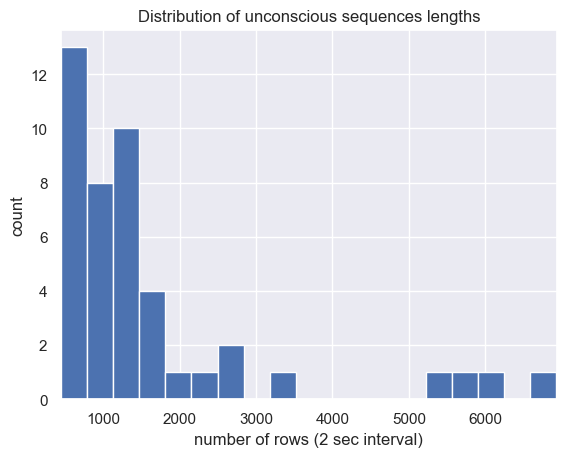


    SUMMARY STATISTICS (CONSCIOUS)
    ------------------
    min = 30, 
    max = 1920, 
    mean = 226.36, 
    std = 387.87, 
    median = 90.0, 
    length = 44
    ------------------
    


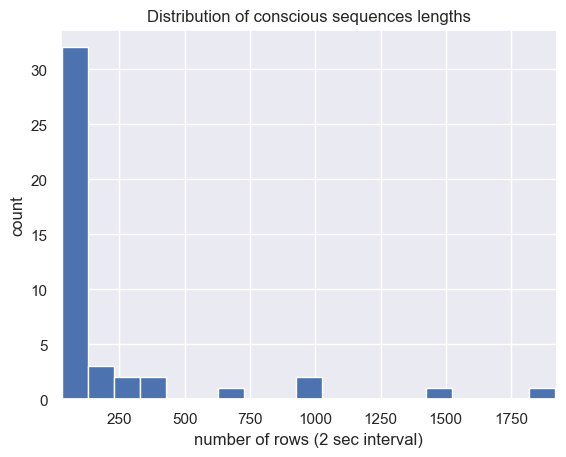

In [19]:
def display_data_summary(state):

    if state == 0:
        state_name = "UNCONSCIOUS"
    elif state == 1:
        state_name = "CONSCIOUS"

    data_lengths_con = []
    for key in data_per_user_dict.keys():
        data_per_user_dict[key]
        data_lengths_con.append(len(data_per_user_dict[key][state]))

    print(f"""
    SUMMARY STATISTICS ({state_name})
    ------------------
    min = {min(data_lengths_con)}, 
    max = {max(data_lengths_con)}, 
    mean = {round(mean(data_lengths_con), 2)}, 
    std = {round(np.std(data_lengths_con), 2)}, 
    median = {median(data_lengths_con)}, 
    length = {len(data_lengths_con)}
    ------------------
    """)

    bins = np.linspace(math.ceil(min(data_lengths_con)), 
                    math.floor(max(data_lengths_con)),
                    20) # fixed number of bins

    plt.xlim([min(data_lengths_con)-5, max(data_lengths_con)+5])

    plt.hist(data_lengths_con, bins=bins, alpha=1)
    plt.title(f'Distribution of {state_name.lower()} sequences lengths')
    plt.xlabel('number of rows (2 sec interval)')
    plt.ylabel('count')

    plt.show()

display_data_summary(0)
display_data_summary(1)

I want the time intervals to be the same, e.g., look at se  aequences of 60 seconds. Two options:

* Take the length of the shortest sequence s, and select a (random) sequence from longer sequences with length s, or;
* Divide longer sequences into cuts of s, meaning that some patients are more represented in the data.

Since the most data points lie close to each other, and the shortest sequence is still reasonably long (1 min), I decided to go for option 1. In this way, I prevent a few number of datapoints to have large influence on later modeling.

To minimize dataloss, I choose to extract 15 30-epoch sequences from the unconsious data - since this is the maximal extraction from the shortest sequence.

In [ ]:
int_length = 30
unconc_num_ints = 15
data_per_user_dict_new = {0: [], 1: []}

def select_consequitive_rows(dataframe, int_length):
    n = random.randint(0, len(dataframe)-int_length)
    return dataframe[n:n+int_length].reset_index(drop=True)

def select_consequitive_rows_intervals(dataframe, unconc_num_ints, int_length):
    data_all_intervals = []
    interval_size = int(np.floor(len(dataframe) / unconc_num_ints))

    end_index = interval_size
    while (end_index < len(dataframe)):
        data_all_intervals.append(select_consequitive_rows(dataframe[(end_index-interval_size):end_index], int_length))
        end_index += interval_size # int_length

    return data_all_intervals

def store_all_interval_data(data_per_user_dict, data_per_user_dict_new, unconc_num_ints, int_length):
    for key in data_per_user_dict.keys():
        df_unconsciousness = data_per_user_dict[key][0]
        df_consciousness = data_per_user_dict[key][1]
        
        data_per_user_dict_new[0].extend(select_consequitive_rows_intervals(df_unconsciousness, unconc_num_ints, int_length))
        data_per_user_dict_new[1].append(select_consequitive_rows(df_consciousness, int_length))
    return data_per_user_dict_new 

sliced_data_dict = store_all_interval_data(data_per_user_dict, data_per_user_dict_new, unconc_num_ints, int_length)
print(len(sliced_data_dict[0]), len(sliced_data_dict[1]))
sliced_data_dict[0][0].head()

Now the data is stored as a dictionary, separating the categories conscious and unconscious (keys), and have a list of slices of data as values.

The next step is to create spectrograms, such that we can use CNN techniques.

In [ ]:
df_test = sliced_data_dict[0][0]

In [ ]:
reduce_pct = 90
fig, ax = plt.subplots(nrows=len(df_test.columns)-reduce_pct, figsize=(15,50*90*0.001), sharex=True)
for i in range(len(df_test.columns) - reduce_pct):
    ax[i].plot(df_test[df_test.columns[i]])
    ax[i].yaxis.set_major_locator(plt.NullLocator())
    ax[i].text(-0.03, 0.5, f'{df_test.columns[i]}', horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']
interp_method = 'lanczos'

# Fixing random state for reproducibility
np.random.seed(123)

fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

ax[0].imshow(df_test.T, cmap='viridis')
ax[0].set_aspect(df_test.shape[0]/df_test.shape[1]) 

ax[1].imshow(df_test.T, interpolation=interp_method, cmap='viridis')
ax[1].set_aspect(df_test.shape[0]/df_test.shape[1]) 

plt.tight_layout()
plt.show()

I choose to save the "spectrograms" (derived from heatmaps), with interpolation to avoid the model picking un on sharp boarders from the heapmap.

In [ ]:
def heapmap_interpolated(df_data, interp_method, impath= '', save=False):
    np.random.seed(123)

    fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(3, 3),
                            subplot_kw={'xticks': [], 'yticks': []})

    ax.imshow(df_data.T, interpolation=interp_method, cmap='viridis');
    ax.set_aspect(df_data.shape[0]/df_test.shape[1])
    plt.tight_layout();

    if save:
        plt.axis('off')
        plt.savefig(impath, dpi=100, pad_inches=0.0, transparent=True, bbox_inches='tight');
    else: plt.show()

In [ ]:
# State 0
def save_spectrogram(state, sliced_data_dict, interpolation_method):
    for i, data in enumerate(sliced_data_dict[state]):
        if state == 0:
            heapmap_interpolated(df_data=data, interp_method=interpolation_method, impath=f'{base_dir}/datasets/state{state}/img{i}.png', save=True) 
        elif state == 1:
            for j in range(0,15):
                heapmap_interpolated(df_data=data, interp_method=interpolation_method, impath=f'{base_dir}/datasets/state{state}/img{i}_{j}.png', save=True)

In [ ]:
for i in range(0,2):
    save_spectrogram(i, sliced_data_dict, interp_method);

Notebook by Alicia HH Larsen

MedAI, Artificial Intelligence Track, TU/e Honors

2024-04-27